## Init Cell

In [1]:
! pip install -q pandas numpy tensorboard catboost scipy matplotlib scikit-learn xgboost nltk colorlog pathlib spacy seaborn optuna mlflow ipywidgets
! spacy download en_core_web_sm
! spacy download ru_core_news_sm

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 7.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [2]:
from src.logger import setup_logger, ROOT_DIR # логирование и корневая папка

# Параметры и конфиги для обучения/экпериментов
from src.ml_utils.config import (
    PreprocessParams,
    TrainingParams,
    Classifier
)

# Утилиты, чтобы не захломлять блокнот
# Все исходники лежат в папке src/ml_utils
from src.ml_utils.utils import (
    filter_n_most_common_categories,
    get_feature_pipeline,
    train_step
)

import warnings  # предупреждения в питухоне
import logging   # логирование базовое
import time  # замеры времени
import json
import gc  # очистка мусора
import os  # для создания папки с сейв-чекпоинтами
from dataclasses import asdict  # перевод датаклассов в словари (будь они прокляты!)
from typing import Dict  # типизация всему голова

# Отрубаем ошибки, потому что мы нефоры (чтобы не захломлять блокнот)
warnings.filterwarnings("ignore", category=UserWarning)
def warn(*args, **kwargs):
    pass
warnings.warn = warn

import pandas as pd  # работа с табличными данными
import joblib  # сохранение моделек и пайплайнов

# Магические методы из sklearn, которые спасают время
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Кастомные бустинги
from catboost import CatBoostClassifier  # от наших слонов
from xgboost import XGBClassifier  # и наших рисных коллег

setup_logger(
    level=logging.INFO,
    stdout_log=True,
    file_log=False
)
logging.info('Modules loaded successfully!')

>>> [2025-02-04 | 05:44:47] logger:70 - WARNING - Log file wasn't created due to file_log=False
>>> [2025-02-04 | 05:44:47] 4073674517:57 - INFO - Modules loaded successfully!


## Data loading & Cleaning

In [3]:
df_data = pd.read_json("data/belta_articles.json") # загружаем данные из json
df_data = filter_n_most_common_categories(df_data, 5)  # выбираем 5 самых встречающихся категории (подробнее о данных в блокноте анализа)
df_data.info() # информация о таблице
df_data.sample(3)  # выборка 3-х случайных строк

<class 'pandas.core.frame.DataFrame'>
Index: 4936 entries, 0 to 7498
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  4936 non-null   object
 1   title       4936 non-null   object
 2   category    4936 non-null   object
 3   tags        4936 non-null   object
 4   text        4936 non-null   object
dtypes: object(5)
memory usage: 231.4+ KB


,article_id,title,category,tags,text
6527,/world/view/v-voz-zamorozili-priem-novogo-pers...,В ВОЗ заморозили прием нового персонала на работу,world,ВОЗ,"3 февраля, Минск /Корр. БЕЛТА/. Руководство Вс..."
4138,/society/view/zavershaetsja-rabota-nad-knigoj-...,"Завершается работа над книгой ""Геноцид белорус...",society,"геноцид,прокуратура","30 января, Минск /Корр. БЕЛТА/. Издательство ""..."
4802,/society/view/genprokuratura-vozbudila-ugolovn...,Генпрокуратура возбудила уголовное дело по фак...,society,"выборы в Беларуси,прокуратура","23 января, Минск /Корр. БЕЛТА/. Генпрокуратура..."


## Utils fuctions

In [4]:
def split_data_step(_df: pd.DataFrame, _preprocess_params: PreprocessParams,  _train_params: TrainingParams):
        """
        Функция подготовки данных
        
        Шаги функции: 
        1) Кодирует категориальный target
        2) Обрабатывает features через Pipeline для преобработки.
           Pipeline состоит из последовательной обработки столбцов через ColumnTransformer:
              * Колонку tags кодирует через OneHotEncoder
              * Колонки title и text обрабатывает NLP Pipeline'ом: Очистка текста, лемматизация/стемминг, токенизация, векторизация
        3) Разделяет данные на тренировочную и тестовую выборки
        
        param: _df (pd.DataFrame): Исходная таблица с сырыми данными
        param: _preprocess_params (PreprocessParams): Параметры для препроцессинга
        param: _train_params (TrainingParams): Параметры для тренировки (по факту нужен для train_test_split)

        Returns: X_train, X_test, y_train, y_test, pipeline_features, TargetEncoder
        """
        logging.info('Split data step has been started')
        le = LabelEncoder() # создаём кодировщик и применяем его к target
        _df['category'] = le.fit_transform(_df['category'].astype(str)) 
        
        # Разбиваем данные на features и target
        X = _df.drop(['category'], axis=1)
        y = _df.pop('category')
        
        # Прогоняем pipeline для features
        pipe_feature = get_feature_pipeline(_preprocess_params)
        display(pipe_feature)
        X_transformed = pipe_feature.fit_transform(X)
        
        try:
            os.makedirs(ROOT_DIR / 'vectorized_data', exist_ok=True)
            joblib.dump(X_transformed, ROOT_DIR / 'vectorized_data/X.pkl')
            joblib.dump(y, ROOT_DIR / 'vectorized_data/y.pkl')
            logging.info(f'Vectorized data was saved at: {ROOT_DIR / "vectorized_data"}')
        except Exception as e:
            logging.error(e, exc_info=True)


        # Разбиваем на тренировочный и тестовый сабсет
        _X_train, _X_test, _y_train, _y_test = train_test_split(
                X_transformed.toarray(),
                y,
                test_size=_train_params.test_size, 
                random_state=_train_params.random_state,
                shuffle=_train_params.shuffle_split
        )

        return _X_train, _X_test, _y_train, _y_test, pipe_feature, le

def evaluation_step(_X_test, _y_test, clf: Classifier) -> Dict:
    """Функция вывода классификационных метрик для оценки модели"""
    logging.info(f'Evaluation step has been started for {clf.name}')
    # Получаем предсказания
    y_pred = clf.estim.predict(_X_test)
    # Ставим читабельный формат для pandas таблиц
    pd.options.display.float_format = '{:,.2f}'.format
    # Вывод таблицы базовых метрик
    metrics_dict = classification_report(y_true=_y_test, y_pred=y_pred, zero_division=0, output_dict=True)
    display(pd.DataFrame(metrics_dict))
    # Вывод матрицы потерь
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(_y_test, y_pred)).plot()
    return metrics_dict

def save_step(clf: Classifier, _preprocess_params: PreprocessParams, _train_params: TrainingParams, 
                    x_pipeline: Pipeline, y_estim: BaseEstimator, m_dict: Dict) -> None:
     """Функция сохранения всего для воспроизведения"""
     logging.info('Save step has been started')
     save_dir = ROOT_DIR / f'pretrained/{clf.name}'
     os.makedirs(save_dir, exist_ok=True)
     joblib.dump(clf.estim, save_dir / "model.pkl") 
     joblib.dump(x_pipeline, save_dir / 'x_pipe.pkl')
     joblib.dump(y_estim, save_dir / 'y_estim.pkl')

     with open(save_dir / 'preprocess_params.json', 'w') as json_file:
        json.dump(asdict(_preprocess_params), json_file, indent=4)

     with open(save_dir / 'train_params.json', 'w') as json_file:
        json.dump(asdict(_train_params), json_file, indent=4)
      
     with open(save_dir / 'metrics_eval.json', 'w') as json_file:
        json.dump(m_dict, json_file, indent=4)

     logging.info(f'Save checkpoint was created successully at: {save_dir}')
     
def experement_step(clf: Classifier, _preprocess_params: PreprocessParams, _train_params: TrainingParams, *args) -> None:
    """
    Функция эксперементов, принимает классификатор, все сабсеты данных и параметры тренировки.
    Выдаёт инфу про обучение и оценку. Заодно и сохраняет всё добро
    """
    logging.info('Experiment step has been started')
    logging.info(f"Garbage collected: {gc.collect()}")
    _X_train, _X_test, _y_train, _y_test, x_estim, y_estim = args
    start_time = time.time()
    trained_clf = train_step(_X_train, _y_train, 
           clf=clf, 
           train_params=_train_params
    )
    logging.info(f"Train step time: {time.time() - start_time:.2f}")
    m_dict = evaluation_step(_X_test, _y_test, trained_clf)
    save_step(clf, _preprocess_params, _train_params, x_estim, y_estim, m_dict)

## Params Cell

In [5]:
# Параметры, ключи в датаклассе сами говорят, за что они отвечают :)
preprocess_params = PreprocessParams(
        spacy_model="ru_core_news_sm",
        remove_punct=True,
        custom_punct=r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',
        remove_stopwords=True,
        lemmatize=True,
        stem=False,
        lowercase=True,
        min_token_length=2,
        verbose=True
)

train_params = TrainingParams(
        test_size=0.2,
        random_state=42,
        shuffle_split=True,
        n_jobs=1
)

In [18]:
classifiers = [
    Classifier(
        name='CatBoostClassifier', 
        estim=CatBoostClassifier(task_type="GPU", devices='0', random_state=train_params.random_state, verbose=False),
        tuning_params=False
    ),
    Classifier(
        name='XGBClassifier',
        estim=XGBClassifier(tree_method="hist", device="cuda", random_state=train_params.random_state),
        tuning_params=False
    ),
    Classifier(
        name='RidgeClassifier',
        estim=RidgeClassifier(random_state=train_params.random_state),
        param_grid={
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 100.0],
            'fit_intercept': [True, False],
            'class_weight': [None, 'balanced'],
        },
        tuning_params=True
    ),
    Classifier(
        name='RandomForestClassifier',
        estim=RandomForestClassifier(random_state=train_params.random_state),
        param_grid = {
            'n_estimators': [50, 100, 200, 300],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2'],
            'bootstrap': [True, False],
            'class_weight': [None, 'balanced', 'balanced_subsample'],
            'oob_score': [True, False]
        },
        tuning_params=True
    ),
    Classifier(
        name='GradientBoostingClassifier',
        estim=GradientBoostingClassifier(random_state=train_params.random_state),
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0],
            'max_features': ['auto', 'sqrt', 'log2'],
            'criterion': ['friedman_mse', 'mse', 'mae']
        },
        tuning_params=False
    ),
    Classifier(
        name='MLPClassifier',
        estim=MLPClassifier(random_state=train_params.random_state),
        param_grid = {
            # 'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001],
            'learning_rate_init': [0.001, 0.01],
            'max_iter': [200, 500],
            # 'batch_size': ['auto', 32, 64, 128],
            # 'early_stopping': [True, False],
            # 'validation_fraction': [0.1, 0.2],
            # 'tol': [1e-4, 1e-3],
            # 'momentum': [0.9, 0.95, 0.99]
        },
        tuning_params=True
    ),
    Classifier(
        name='KNeighborsClassifier',
        estim=KNeighborsClassifier(),
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'leaf_size': [10, 20, 30, 50],
            'p': [1, 2],
            'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev']
        },
        tuning_params=True
    )
]

# Main Cell

In [7]:
packed_data_from_splits = split_data_step(
    df_data.copy(deep=True), 
    preprocess_params, 
    train_params
)

>>> [2025-02-04 | 05:44:47] 724128593:19 - INFO - Split data step has been started
>>> [2025-02-04 | 05:44:47] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 05:44:47] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 05:44:48] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 05:44:48] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 05:44:49] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 05:44:49] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 05:44:50] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.1

Pipeline(steps=[('column_processor',
                 ColumnTransformer(sparse_threshold=1,
                                   transformers=[('text_pipeline',
                                                  Pipeline(steps=[('cleaner',
                                                                   TextCleaner(params=PreprocessParams(spacy_model='ru_core_news_sm',
                                                                                                       remove_punct=True,
                                                                                                       custom_punct='[!"#$%&\\\'()*+,-./:;<=>?@[\\\\]^_`{|}~]',
                                                                                                       remove_stopwords=True,
                                                                                                       lemmatize=True,
                                                                                                       stem=False,
                                                                                                       lowercase=True,
                                                                                                       min_token_length...
                                                                   TokenProcessor(params=PreprocessParams(spacy_model='ru_core_news_sm',
                                                                                                          remove_punct=True,
                                                                                                          custom_punct='[!"#$%&\\\'()*+,-./:;<=>?@[\\\\]^_`{|}~]',
                                                                                                          remove_stopwords=True,
                                                                                                          lemmatize=True,
                                                                                                          stem=False,
                                                                                                          lowercase=True,
                                                                                                          min_token_length=2,
                                                                                                          verbose=True))),
                                                                  ('vectorizer',
                                                                   TfidfVectorizer())],
                                                           verbose=True),
                                                  'title'),
                                                 ('tags_preprocess',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['tags'])],
                                   verbose=True))],
         verbose=True)

>>> [2025-02-04 | 05:44:51] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 05:44:51] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 05:44:52] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 05:44:52] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 05:44:53] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 05:44:53] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 05:44:54] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 05:44:54] wrapper:25 - IN

### CatBoostClassifier

>>> [2025-02-04 | 06:10:14] 724128593:92 - INFO - Experiment step has been started
>>> [2025-02-04 | 06:10:14] 724128593:93 - INFO - Garbage collected: 840
>>> [2025-02-04 | 06:10:14] utils:109 - INFO - Fit step has started for CatBoostClassifier
>>> [2025-02-04 | 06:11:41] utils:111 - INFO - Fit step finished successfully!
>>> [2025-02-04 | 06:11:41] 724128593:100 - INFO - Train step time: 87.00
>>> [2025-02-04 | 06:11:41] 724128593:54 - INFO - Evaluation step has been started for CatBoostClassifier


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.92,0.90,0.86,1.00,0.98,0.93,0.93,0.93
recall,0.93,0.90,0.87,0.99,0.97,0.93,0.93,0.93
f1-score,0.93,0.90,0.87,1.00,0.97,0.93,0.93,0.93
support,198.00,198.00,191.00,189.00,212.00,0.93,988.00,988.00


>>> [2025-02-04 | 06:11:49] 724128593:69 - INFO - Save step has been started
>>> [2025-02-04 | 06:12:04] 724128593:85 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/CatBoostClassifier


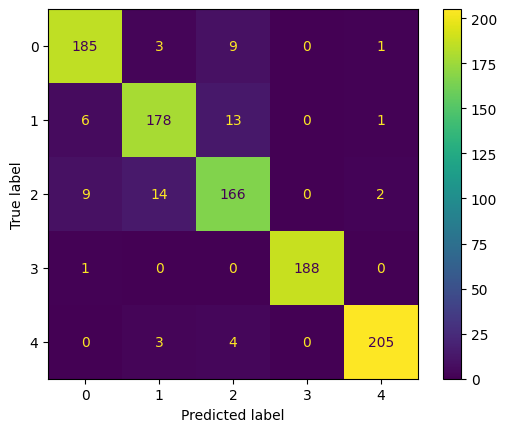

In [8]:
experement_step(classifiers[0], preprocess_params, train_params, *packed_data_from_splits)

### XGBClassifier

>>> [2025-02-04 | 06:12:05] 724128593:92 - INFO - Experiment step has been started
>>> [2025-02-04 | 06:12:05] 724128593:93 - INFO - Garbage collected: 7359
>>> [2025-02-04 | 06:12:05] utils:109 - INFO - Fit step has started for XGBClassifier
>>> [2025-02-04 | 06:12:33] utils:111 - INFO - Fit step finished successfully!
>>> [2025-02-04 | 06:12:33] 724128593:100 - INFO - Train step time: 28.79
>>> [2025-02-04 | 06:12:33] 724128593:54 - INFO - Evaluation step has been started for XGBClassifier


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.94,0.94,0.88,0.99,0.99,0.95,0.95,0.95
recall,0.94,0.93,0.92,0.99,0.97,0.95,0.95,0.95
f1-score,0.94,0.94,0.90,0.99,0.98,0.95,0.95,0.95
support,198.00,198.00,191.00,189.00,212.00,0.95,988.00,988.00


>>> [2025-02-04 | 06:12:34] 724128593:69 - INFO - Save step has been started
>>> [2025-02-04 | 06:12:49] 724128593:85 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/XGBClassifier


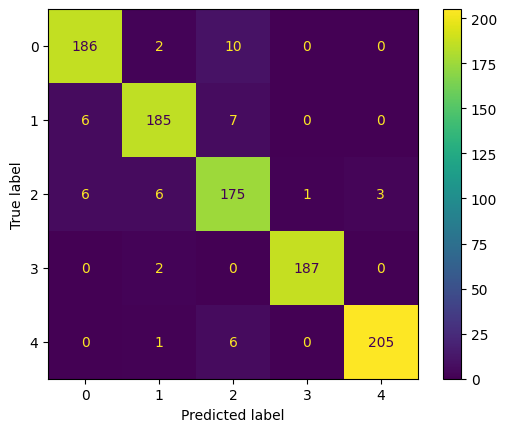

In [9]:
experement_step(classifiers[1], preprocess_params, train_params, *packed_data_from_splits)

### RidgeClassifier

>>> [2025-02-04 | 13:42:12] 724128593:92 - INFO - Experiment step has been started
>>> [2025-02-04 | 13:42:12] 724128593:93 - INFO - Garbage collected: 1376
>>> [2025-02-04 | 13:42:12] utils:81 - INFO - Tuning params step has started for RidgeClassifier
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 8
min_resources_: 30
max_resources_: 3948
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 30
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 12
n_resources: 60
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 2
n_candidates: 6
n_resources: 120
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 3
n_resources: 240
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 4
n_candidates: 2
n_resources: 480
Fitting 3 folds for each of 2 candidates, totalling 6 fits
>>> [2025-02-04 | 13:42:23] utils:86 - I

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.91,0.93,0.91,0.99,1.00,0.95,0.95,0.95
recall,0.95,0.92,0.89,1.00,0.99,0.95,0.95,0.95
f1-score,0.93,0.93,0.90,1.00,0.99,0.95,0.95,0.95
support,198.00,198.00,191.00,189.00,212.00,0.95,988.00,988.00


>>> [2025-02-04 | 13:42:28] 724128593:69 - INFO - Save step has been started
>>> [2025-02-04 | 13:42:41] 724128593:85 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/RidgeClassifier


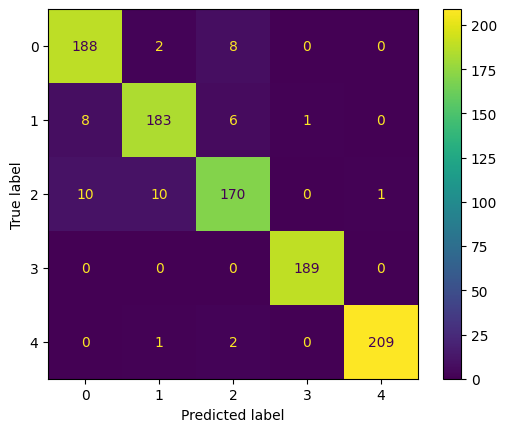

In [19]:
experement_step(classifiers[2], preprocess_params, train_params, *packed_data_from_splits)

### RandomForestClassifier

>>> [2025-02-04 | 13:42:49] 724128593:92 - INFO - Experiment step has been started
>>> [2025-02-04 | 13:42:49] 724128593:93 - INFO - Garbage collected: 7404
>>> [2025-02-04 | 13:42:49] utils:81 - INFO - Tuning params step has started for RandomForestClassifier
n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 30
max_resources_: 3948
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 131
n_resources: 30
Fitting 3 folds for each of 131 candidates, totalling 393 fits
----------
iter: 1
n_candidates: 66
n_resources: 60
Fitting 3 folds for each of 66 candidates, totalling 198 fits
----------
iter: 2
n_candidates: 33
n_resources: 120
Fitting 3 folds for each of 33 candidates, totalling 99 fits
----------
iter: 3
n_candidates: 17
n_resources: 240
Fitting 3 folds for each of 17 candidates, totalling 51 fits
----------
iter: 4
n_candidates: 9
n_resources: 480
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 5
n_ca

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.83,0.93,0.87,0.98,0.97,0.91,0.92,0.92
recall,0.97,0.87,0.76,0.99,0.98,0.91,0.91,0.91
f1-score,0.89,0.90,0.81,0.99,0.97,0.91,0.91,0.91
support,198.00,198.00,191.00,189.00,212.00,0.91,988.00,988.00


>>> [2025-02-04 | 13:52:04] 724128593:69 - INFO - Save step has been started
>>> [2025-02-04 | 13:52:18] 724128593:85 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/RandomForestClassifier


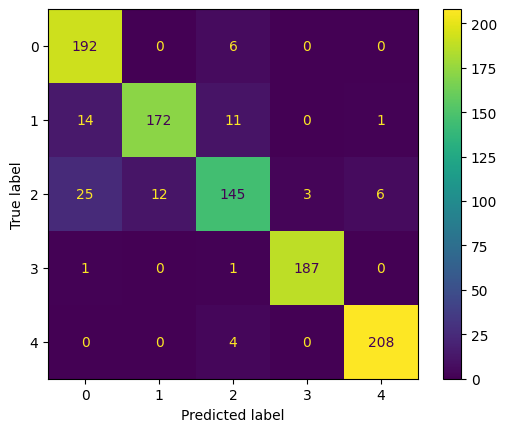

In [20]:
experement_step(classifiers[3], preprocess_params, train_params, *packed_data_from_splits)

### GradientBoostingClassifier

>>> [2025-02-04 | 06:13:44] 724128593:92 - INFO - Experiment step has been started
>>> [2025-02-04 | 06:13:44] 724128593:93 - INFO - Garbage collected: 7440
>>> [2025-02-04 | 06:13:44] utils:109 - INFO - Fit step has started for GradientBoostingClassifier
>>> [2025-02-04 | 07:05:59] utils:111 - INFO - Fit step finished successfully!
>>> [2025-02-04 | 07:05:59] 724128593:100 - INFO - Train step time: 3135.18
>>> [2025-02-04 | 07:05:59] 724128593:54 - INFO - Evaluation step has been started for GradientBoostingClassifier


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.93,0.93,0.83,0.99,0.99,0.93,0.93,0.93
recall,0.91,0.90,0.91,0.98,0.96,0.93,0.93,0.93
f1-score,0.92,0.91,0.87,0.99,0.97,0.93,0.93,0.93
support,198.00,198.00,191.00,189.00,212.00,0.93,988.00,988.00


>>> [2025-02-04 | 07:06:00] 724128593:69 - INFO - Save step has been started
>>> [2025-02-04 | 07:06:17] 724128593:85 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/GradientBoostingClassifier


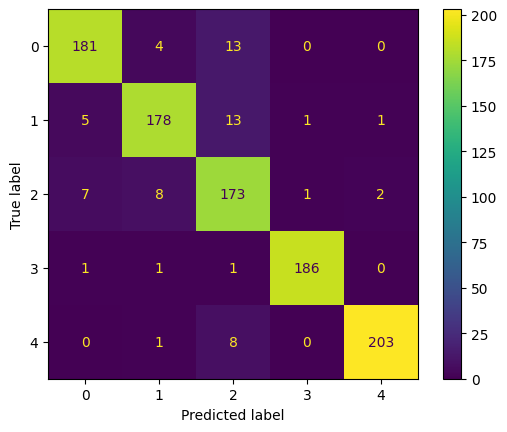

In [12]:
experement_step(classifiers[4], preprocess_params, train_params, *packed_data_from_splits)

### MLPClassifier

>>> [2025-02-04 | 13:52:19] 724128593:92 - INFO - Experiment step has been started
>>> [2025-02-04 | 13:52:19] 724128593:93 - INFO - Garbage collected: 7620
>>> [2025-02-04 | 13:52:19] utils:81 - INFO - Tuning params step has started for MLPClassifier
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 8
min_resources_: 30
max_resources_: 3948
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 32
n_resources: 30
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 1
n_candidates: 16
n_resources: 60
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 2
n_candidates: 8
n_resources: 120
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 4
n_resources: 240
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 480
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 5
n_candidates: 1
n_reso

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.92,0.93,0.90,1.00,1.00,0.95,0.95,0.95
recall,0.94,0.91,0.91,0.99,0.98,0.95,0.95,0.95
f1-score,0.93,0.92,0.90,1.00,0.99,0.95,0.95,0.95
support,198.00,198.00,191.00,189.00,212.00,0.95,988.00,988.00


>>> [2025-02-04 | 14:34:26] 724128593:69 - INFO - Save step has been started
>>> [2025-02-04 | 14:34:42] 724128593:85 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/MLPClassifier


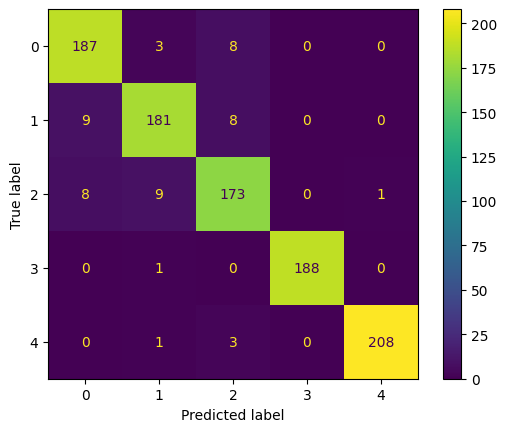

In [21]:
experement_step(classifiers[5], preprocess_params, train_params, *packed_data_from_splits)

### KNeighborsClassifier

>>> [2025-02-04 | 14:34:48] 724128593:92 - INFO - Experiment step has been started
>>> [2025-02-04 | 14:34:49] 724128593:93 - INFO - Garbage collected: 7404
>>> [2025-02-04 | 14:34:49] utils:81 - INFO - Tuning params step has started for KNeighborsClassifier
n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 30
max_resources_: 3948
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 131
n_resources: 30
Fitting 3 folds for each of 131 candidates, totalling 393 fits
----------
iter: 1
n_candidates: 66
n_resources: 60
Fitting 3 folds for each of 66 candidates, totalling 198 fits
----------
iter: 2
n_candidates: 33
n_resources: 120
Fitting 3 folds for each of 33 candidates, totalling 99 fits
----------
iter: 3
n_candidates: 17
n_resources: 240
Fitting 3 folds for each of 17 candidates, totalling 51 fits
----------
iter: 4
n_candidates: 9
n_resources: 480
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 5
n_cand

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.74,0.96,0.35,0.99,0.99,0.63,0.81,0.81
recall,0.63,0.33,0.90,0.85,0.47,0.63,0.64,0.63
f1-score,0.68,0.49,0.51,0.92,0.64,0.63,0.65,0.65
support,198.00,198.00,191.00,189.00,212.00,0.63,988.00,988.00


>>> [2025-02-04 | 14:36:22] 724128593:69 - INFO - Save step has been started
>>> [2025-02-04 | 14:36:38] 724128593:85 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/KNeighborsClassifier


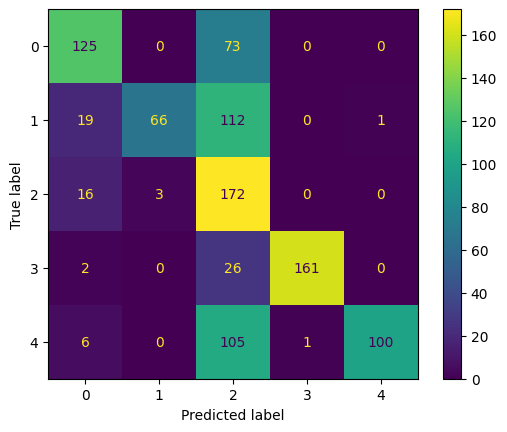

In [22]:
experement_step(classifiers[6], preprocess_params, train_params, *packed_data_from_splits)